In [18]:
import numpy as np
import pandas as pd
from collections import Counter
from astropy.table import Table
import astropy.units as u
import h5py

import matplotlib.pyplot as plt

from qmostetc import SEDTemplate, QMostObservatory, Ruleset, Rule, Spectrum, Target, RulesRepository, QMostETC, L1DXU
from qmostetc.units import VEGAmag
from qmostetc.catalog import _split_magtype as split_magtype
from qmostetc.exposure import Exposure

* Dark
* Grey
* Bright
* Super-bright

In [5]:
cat = Table.read('./../ByCycle_balanced_subset_QSOs.fits', format='fits').to_pandas()

## Mock observations

### Flat spectrum

In [ ]:
# wavelen = np.linspace(3000., 11000., 10000) * u.angstrom
# wavelen

<Quantity [ 3000.        ,  3000.80008001,  3001.60016002, ...,
           10998.39983998, 10999.19991999, 11000.        ] Angstrom>

In [ ]:
# flux = np.ones(wavelen.shape) * u.erg/(u.cm**2 * u.s * u.angstrom)
# spec = Spectrum(wavelen, flux)
# # print(spec.to('erg / (ang m² s)').flux)

In [137]:
template_4fs = Table.read('./../4FS_spectral_templates/4M_templ_z1_00_extended.fits')
template_4fs

LAMBDA,FLUX_DENSITY
Angstrom,erg / (Angstrom s cm2)
float64,float64
5.0,2.328523
10.0,2.328523
15.0,2.328523
20.0,2.328523
25.0,2.328523
30.0,2.328523
35.0,2.328523
40.0,2.328523


In [138]:
spec = Spectrum(np.asarray(template_4fs['LAMBDA']) * u.Angstrom, 
                np.asarray(template_4fs['FLUX_DENSITY']) * u.erg / (u.cm**2 * u.s * u.Angstrom)
                )

In [139]:
spec.wavelength

<Quantity [5.0e+00, 1.0e+01, 1.5e+01, ..., 9.6e+04, 2.0e+05, 4.0e+05] Angstrom>

In [141]:
spec.flux

<Quantity [2.328523, 2.328523, 2.328523, ..., 0.117703, 0.038892, 0.020738] erg / (Angstrom s cm2)>

In [177]:
template = SEDTemplate(spec)#.to('erg / (nm m² s)'))
flux = template(20*u.ABmag, 'DECam.z')

### Observations

In [192]:
qmost = QMostObservatory('hrs')  # high-resolution
obs = qmost(45*u.deg,  # airmass
            1.3*u.arcsec,  # seeing
            'gray')  # moon conditions

obs.set_target(flux, 'point')
tbl = obs.expose((10000*60)*u.s)

In [179]:
tbl_pd = tbl.to_pandas()
tbl_pd

,wavelength,binwidth,efficiency,gain,target,sky,dark,ron,noise,arm
0,392.606928,0.007923,0.102040,1.051500,608.297636,275.355546,52.049396,6.208353,20.658615,blue
1,392.614851,0.007922,0.102070,1.051500,608.469255,275.085464,52.049396,6.208353,20.652492,blue
2,392.622773,0.007922,0.102100,1.051500,608.636734,276.820654,52.049396,6.208353,20.694863,blue
3,392.630695,0.007922,0.102131,1.051500,608.802520,287.908785,52.049396,6.208353,20.961443,blue
4,392.638617,0.007922,0.102161,1.051500,608.968374,312.869371,52.049396,6.208353,21.548997,blue
...,...,...,...,...,...,...,...,...,...,...
18013,678.950329,0.010058,0.197119,1.072625,1859.775802,894.290938,67.405646,5.165317,34.268859,red
18014,678.960387,0.010058,0.197090,1.072625,1859.425709,981.141512,67.405646,5.165317,35.512959,red
18015,678.970445,0.010058,0.197062,1.072625,1859.079348,981.795439,67.405646,5.165317,35.521677,red
18016,678.980502,0.010057,0.197033,1.072625,1858.746365,897.620249,67.405646,5.165317,34.315901,red


### Check L1 Output

In [204]:
dxu = L1DXU(qmost, tbl, (100000*60)*u.s)
dxu

In [205]:
len(tbl_pd.loc[tbl_pd['arm']=='blue'])

5971

In [206]:
len(dxu.sensitivity('blue'))

8578

In [207]:
dxu.sensitivity('blue')

<Quantity [6.98156535e-16, 6.98017292e-16, 6.97877452e-16, ...,
           3.26178667e-16, 3.26187275e-16, 3.26195752e-16] erg / (adu cm2)>

In [208]:
dxu._arm_slice('blue')

slice(0, 8578, None)

In [209]:
dxu.per_arm('blue')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x148965a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1499f3350>]

In [210]:
dxu.joined_spectrum()

/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


WAVE,FLUX,ERR_FLUX,QUAL,FLUX_NOSS,ERR_FLUX_NOSS
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float32,float32,float32,int32,float32,float32
3926.10,7.53023e-19,1.10100e-19,0,4.59930e-18,1.10100e-19
3926.15,8.15397e-19,1.10053e-19,0,4.65895e-18,1.10053e-19
3926.20,8.51159e-19,1.10058e-19,0,4.69578e-18,1.10058e-19
3926.25,7.58203e-19,1.10186e-19,0,4.61741e-18,1.10186e-19
3926.30,7.45951e-19,1.10866e-19,0,4.67355e-18,1.10866e-19
3926.35,7.80391e-19,1.11892e-19,0,4.81334e-18,1.11892e-19
3926.40,8.67101e-19,1.14031e-19,0,5.11913e-18,1.14031e-19
3926.45,8.35413e-19,1.15664e-19,0,5.25918e-18,1.15664e-19


In [211]:
dxu.joined_spectrum()['WAVE'], spec.wavelength

/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Quantity [3926.1 , 3926.15, 3926.2 , ..., 6789.8 , 6789.85, 6789.9 ] Angstrom>,
 <Quantity [5.0e+00, 1.0e+01, 1.5e+01, ..., 9.6e+04, 2.0e+05, 4.0e+05] Angstrom>)

In [212]:
dxu.joined_spectrum()['FLUX'], spec.flux

/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Quantity [7.5302310e-19, 8.1539711e-19, 8.5115908e-19, ..., 6.1097266e-19,
            6.1572761e-19, 6.0688422e-19] erg / (Angstrom s cm2)>,
 <Quantity [2.328523, 2.328523, 2.328523, ..., 0.117703, 0.038892, 0.020738] erg / (Angstrom s cm2)>)

/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


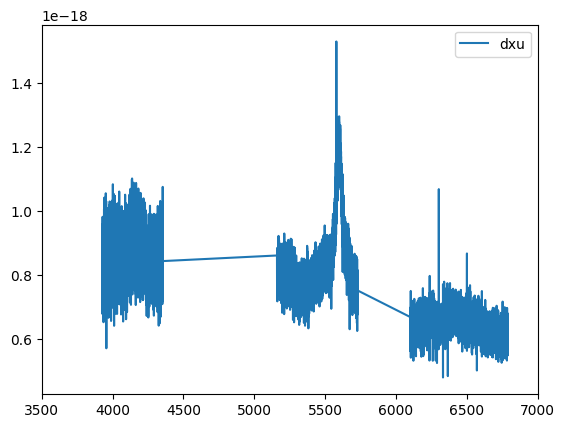

In [214]:
plt.plot(dxu.joined_spectrum()['WAVE'], dxu.joined_spectrum()['FLUX'], label='dxu')
#plt.plot(spec.wavelength, spec.flux, label='spec')

plt.legend()
# plt.yscale('log')

plt.xlim(3500, 7000)

plt.show()

In [12]:
tbl['SNR'] = tbl['target'] / tbl['noise']
tbl

wavelength,binwidth,efficiency,gain,target,sky,dark,ron,noise,arm,SNR
nm,nm,electron / ph,electron / adu,electron,electron,electron,electron,electron,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64
392.60692846030474,0.007922513014023025,0.1020396156178534,1.0514999999999999,1.805529226681413,14.593843928305944,2.7586179791666665,6.208353296809067,7.596159673950649,blue,0.23768974115605762
392.61485086465916,0.007922295694868353,0.10206980419587068,1.0514999999999999,1.806100828950598,14.579529603638992,2.7586179791666665,6.208353296809067,7.595255036518278,blue,0.23779330914719726
392.6227730516839,0.007922078354624773,0.10210015341074719,1.0514999999999999,1.806740245768082,14.671494658468434,2.7586179791666665,6.208353296809067,7.601348797509767,blue,0.23768679663272094
392.63069502135795,0.007921860993405971,0.10213065037771042,1.0514999999999999,1.8073969826660659,15.259165611252218,2.7586179791666665,6.208353296809067,7.639949687732567,blue,0.23657184360365552
392.63861677366026,0.007921643611211948,0.10216126507272123,1.0514999999999999,1.8079817714615165,16.582076675705693,2.7586179791666665,6.208353296809067,7.726080965427031,blue,0.23401020252725074
392.64653830856986,0.00792142620798586,0.10219198240460484,1.0514999999999999,1.8084995900329757,17.317957185792558,2.7586179791666665,6.208353296809067,7.773591538857197,blue,0.23264659340447477
392.65445962606566,0.007921208783670863,0.10222281478523706,1.0514999999999999,1.8089984661243357,16.251485076522012,2.7586179791666665,6.208353296809067,7.704722719203659,blue,0.23479085906822994
392.6623807261268,0.007920991338608019,0.10225372022098599,1.0514999999999999,1.8094994757728342,14.914439506941877,2.7586179791666665,6.208353296809067,7.617493526080701,blue,0.23754525941866406


In [13]:
wavelen = np.linspace(300., 1100., 10000) * u.nm
flat_flux = np.ones(wavelen.shape) * u.photon/(u.m**2*u.s*u.nm)

## Saving debugging

In [14]:
def SNR_4MOST_like(mag, t_exp, wavelen=wavelen, template_flux=flat_flux, mag_type='DECam.z', airmass=45, seeing=1.3, moon='gray'):
    '''
    mag: magnitude
    t_exp: exposure time [mins]
    wavelen: wavelength grid [nm]
    flux: flux array [any]
    mag_type: filter name
    airmass [degrees]
    seeing [arcsec]
    moon condition: 'dark', 'gray', 'bright' or 'super-bright'
    '''
    mag = mag

    spec = Spectrum(wavelen, template_flux)

    template = SEDTemplate(spec)

    flux = template(mag*u.ABmag, mag_type)

    qmost = QMostObservatory('hrs')  # high-resolution
    obs = qmost(airmass*u.deg,  # airmass
                seeing*u.arcsec,  # seeing
                moon)  # moon conditions

    obs.set_target(flux, 'point')

    observation = obs.expose((t_exp*60)*u.s)


    return observation[['wavelength', 'binwidth', 'target', 'sky', 'dark', 'ron', 'noise', 'arm']]

In [15]:
cols_to_save_from_cat = ['RA', 'DEC', 'SUBSURVEY', 'MAG', 'REDSHIFT_ESTIMATE', 'REDSHIFT_ERROR', 'TEXP_D', 'TEXP_G', 'TEXP_B', 'TEXP_S']
cols_to_save_from_etc = ['wavelength', 'binwidth', 'target', 'sky', 'dark', 'ron', 'noise',  # 'SNR', 
                         'arm_int']

In [12]:
airmass = 45
seeing = 1.3
moon = 'gray'
save_name = 'SNR_curves_ByCycle_cat_moon_' + moon + '_airmass_' + str(airmass) + '_seeing_' + str(seeing).replace('.', '_')

In [16]:
def binarize_arm(arm_str):

    if arm_str == 'blue':
        return 1
    elif arm_str == 'green':
        return 2
    elif arm_str == 'red':
        return 3

In [17]:
def bin_arm_str_array(arm_str_array):

    arm_int_array = np.zeros(len(arm_str_array))

    for i in range(len(arm_str_array)):
        arm_int_array[i] = int(binarize_arm(arm_str_array[i]))

    return arm_int_array

In [ ]:
with h5py.File(save_name + '.hdf5', 'w') as f:

    f.clear()

    for cat_col in cols_to_save_from_cat:


        if cat[cat_col].dtype.kind == 'S' or cat[cat_col].dtype.kind == 'U' or cat[cat_col].dtype.kind == 'O':
            f.create_dataset(cat_col, data=np.array(cat[cat_col].astype('S')))

        else:
            f.create_dataset(cat_col, data=cat[cat_col])

    n_objects = cat.shape[0]

    test_obs = SNR_4MOST_like(cat['MAG'][0], cat['TEXP_G'][0])
    test_obs['arm_int'] = bin_arm_str_array(np.asarray(test_obs['arm']))

    for etc_col in cols_to_save_from_etc:

        test_data = test_obs[etc_col]

        if np.issubdtype(np.array(test_data).dtype, np.character) or isinstance(test_data[0], str):

            if np.array(test_data).ndim == 0:
                dtype = h5py.special_dtype(vlen=str)
                f.create_dataset(etc_col, shape=(n_objects,), dtype=dtype)
            else:
                max_length = max([len(s) for s in test_data])
                dtype = h5py.special_dtype(vlen=str)
                shape = (n_objects,) + np.array(test_data).shape
                f.create_dataset(etc_col, shape=shape, dtype=dtype)
        
        else:

            shape = (n_objects,) + test_data.shape
            f.create_dataset(etc_col, shape=shape)

    for i in range(n_objects):

        if i % 10000 == 0.0:
            print(str(i * 100 / n_objects), '% \n')

        obs = SNR_4MOST_like(cat['MAG'][i], cat['TEXP_G'][i])

        obs['arm_int'] = bin_arm_str_array(np.asarray(obs['arm']))

        for etc_col_ in cols_to_save_from_etc:

            f[etc_col_][i] = np.asarray(obs[etc_col_])

RA
DEC
SUBSURVEY
MAG
REDSHIFT_ESTIMATE
REDSHIFT_ERROR
TEXP_D
TEXP_G
TEXP_B
TEXP_S
first for loop etc_col
wavelength
shape (1674374, 18018)
binwidth
shape (1674374, 18018)
target
shape (1674374, 18018)
sky
shape (1674374, 18018)
dark
shape (1674374, 18018)
ron
shape (1674374, 18018)
noise
shape (1674374, 18018)
arm_int
shape (1674374, 18018)
for loop through objects
0
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
1
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
2
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
3
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
4
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
5
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
6
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise
arm_int
7
second for loop etc_col
wavelength
binwidth
target
sky
dark
ron
noise


In [15]:
testing = h5py.File(save_name+'.hdf5', 'r')

In [16]:
testing.keys()

<KeysViewHDF5 ['DEC', 'MAG', 'RA', 'REDSHIFT_ERROR', 'REDSHIFT_ESTIMATE', 'SUBSURVEY', 'TEXP_B', 'TEXP_D', 'TEXP_G', 'TEXP_S', 'arm_int', 'binwidth', 'dark', 'noise', 'ron', 'sky', 'target', 'wavelength']>

In [17]:
testing['wavelength'][:].shape

(1674374, 18018)

In [19]:
testing['wavelength'][0].shape

(18018,)

In [35]:
for key in testing.keys():
    print(key)
    print(testing[key][:].shape)
    print(' ')

DEC
(1674374,)
 
MAG
(1674374,)
 
RA
(1674374,)
 
REDSHIFT_ERROR
(1674374,)
 
REDSHIFT_ESTIMATE
(1674374,)
 
SUBSURVEY
(1674374,)
 
TEXP_B
(1674374,)
 
TEXP_D
(1674374,)
 
TEXP_G
(1674374,)
 
TEXP_S
(1674374,)
 
arm_int
(1674374, 18018)
 
binwidth


KeyboardInterrupt: 

## Plotting

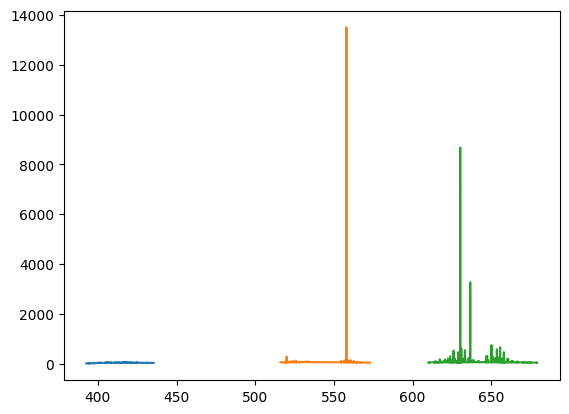

In [150]:
plt.plot(tbl[tbl['arm']=="blue"]['wavelength'],tbl[tbl['arm']=="blue"]['sky'])
plt.plot(tbl[tbl['arm']=="green"]['wavelength'],tbl[tbl['arm']=="green"]['sky'])
plt.plot(tbl[tbl['arm']=="red"]['wavelength'],tbl[tbl['arm']=="red"]['sky'])

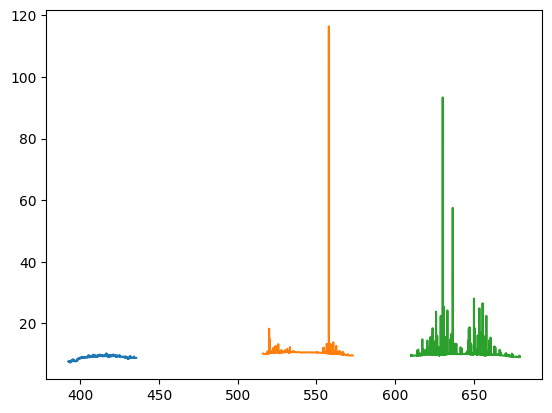

In [149]:
plt.plot(tbl[tbl['arm']=="blue"]['wavelength'],tbl[tbl['arm']=="blue"]['noise'])
plt.plot(tbl[tbl['arm']=="green"]['wavelength'],tbl[tbl['arm']=="green"]['noise'])
plt.plot(tbl[tbl['arm']=="red"]['wavelength'],tbl[tbl['arm']=="red"]['noise'])

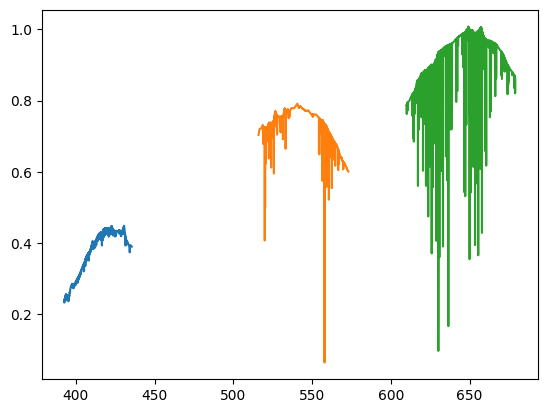

In [148]:
plt.plot(tbl[tbl['arm']=="blue"]['wavelength'],tbl[tbl['arm']=="blue"]['target']/tbl[tbl['arm']=="blue"]['noise'])
plt.plot(tbl[tbl['arm']=="green"]['wavelength'],tbl[tbl['arm']=="green"]['target']/tbl[tbl['arm']=="green"]['noise'])
plt.plot(tbl[tbl['arm']=="red"]['wavelength'],tbl[tbl['arm']=="red"]['target']/tbl[tbl['arm']=="red"]['noise'])

# plt.xlim(620, 650)
# plt.ylim(30, 40)

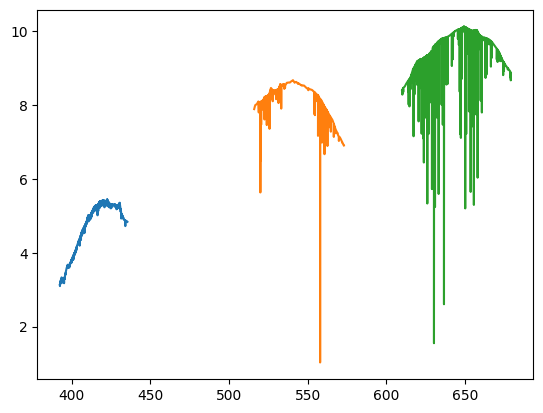

In [ ]:
flux = template(17*u.ABmag, 'DECam.z')
obs.set_target(flux, 'point')
tbl = obs.expose((53.7*60)*u.s)

plt.plot(tbl[tbl['arm']=="blue"]['wavelength'],tbl[tbl['arm']=="blue"]['target']/tbl[tbl['arm']=="blue"]['noise'])
plt.plot(tbl[tbl['arm']=="green"]['wavelength'],tbl[tbl['arm']=="green"]['target']/tbl[tbl['arm']=="green"]['noise'])
plt.plot(tbl[tbl['arm']=="red"]['wavelength'],tbl[tbl['arm']=="red"]['target']/tbl[tbl['arm']=="red"]['noise'])


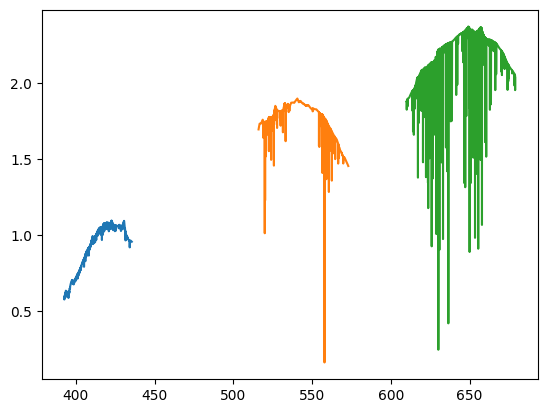

In [ ]:
flux = template(19*u.ABmag, 'DECam.z')
obs.set_target(flux, 'point')
tbl = obs.expose((53.7*60)*u.s)

plt.plot(tbl[tbl['arm']=="blue"]['wavelength'],tbl[tbl['arm']=="blue"]['target']/tbl[tbl['arm']=="blue"]['noise'])
plt.plot(tbl[tbl['arm']=="green"]['wavelength'],tbl[tbl['arm']=="green"]['target']/tbl[tbl['arm']=="green"]['noise'])
plt.plot(tbl[tbl['arm']=="red"]['wavelength'],tbl[tbl['arm']=="red"]['target']/tbl[tbl['arm']=="red"]['noise'])